# Load Libraries

In [1]:
import os
os.chdir("..")
from parc import model
from parc import IO
from parc import losses
from parc import graphs
import keras
import numpy as np

# Initialize Parameters

### Adaptable Input Data 

In [2]:
#initialize input data characteristics
input_img_size = 485  #image size
case_numbers = 2      #number of cases
total_time_steps = 20       #number of time steps
del_t = 0.79*(10**-9) #time step size

### Adaptable Model Parameters 

In [3]:
#initialize adaptable model parameters
input_size = (None,None,2)
depth = 3
kernel_size = 5
numFeatureMaps = 128

#initialize loss parameters
weight_loss = [4,1,1] #initial timestep weights, middle weights, late weights

### Adaptable Post-Processing 

In [5]:
time_steps = 20   #desired time steps for graphs/losses
t_idx = del_t * np.arange(1,time_steps)

# Initialization

### Parse and Split Data 

In [6]:
#Parse the raw data and return microstructure data and temperature/pressure outputs
data_in, total_output = IO.parse_data("data/raw",input_img_size,case_numbers,time_steps,del_t)

#Split data into training, validation, and testing sets
X_train, y_train, X_val, y_val, test_X, test_Y = IO.split_data(data_in,total_output,splits=[0.5, 0, 0.5])

max and min of channel 0 are:  4000.0 300.0
max and min of channel 1 are:  33671716000.0 -1553485500.0
max and min of channel 2 are:  4683544303797.468 -4242651063291.1387
max and min of channel 3 are:  4.262242531645571e+19 -3.252435227848101e+19
Finished Processing Data
shape of microstructure data is:  (2, 240, 240, 2)
shape of output data is:  (2, 240, 240, 20, 4)
2
1
1
2
(1, 240, 240, 2)
(1, 240, 240, 20, 4)
(0, 240, 240, 2)
(0, 240, 240, 20, 4)
(1, 240, 240, 2)
(1, 240, 240, 20, 4)


### Create Training Model

In [7]:
#initilize model and model parameters
parc_model = model.parc(input_size,time_steps,depth,kernel_size,numFeatureMaps)
loss = ["mse", "mse"]
loss_weights = [1, 1]
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["mae"]
parc_model.compile(loss = loss,loss_weights = loss_weights,optimizer = optimizer,metrics = metrics)

# Training

### 5-Dimensional Format Training 

In [8]:
########for 5 dimensional data format############
#x_tn_init = y_train[:,:,:,0,:1]
#x_val_init = y_val[:,:,:,0,:1]

#train the model using training set 
#history = parc_model.fit(
#    x=[X_train, x_tn_init],
#    y=[y_train[:, :, :, 1:, :1], y_train[:, :, :, 1:, 2:3]],
#    validation_data=([X_val, x_val_init], [y_val[:, :, :, :, :1], y_val[:, :, :, :, 2:3]]),
#    batch_size=1,
#    epochs=2,
#)
################################################

### 4-Dimensional Format Training 

In [9]:
#####for 4 dimensional data format#######
#reshape to match old data format
y_train = IO.reshape_old(y_train)
y_val = IO.reshape_old(y_val)
test_Y = IO.reshape_old(test_Y)

x_tn_init = y_train[:,:,:,0:2]
x_val_init = y_val[:,:,:,0:2]
x_test_init = test_Y[:,:,:,0:2]

#train the model using training set, skip this part if already trained
history = parc_model.fit(
    x=[X_train, x_tn_init],
    y=[y_train[:, :, :, 2:40], y_train[:, :, :, 40:]],
    validation_data=([X_val, x_val_init], [y_val[:, :, :, 2:40], y_val[:, :, :, 40:]]),
    batch_size=1,
    epochs=2,
)

Starting shape of data:  (1, 240, 240, 20, 4)
Reformatted data shape:  (1, 240, 240, 78)
Starting shape of data:  (0, 240, 240, 20, 4)
Reformatted data shape:  (0, 240, 240, 78)
Starting shape of data:  (1, 240, 240, 20, 4)
Reformatted data shape:  (1, 240, 240, 78)
Epoch 1/2
1/1 [==============================] - 313s 313s/step - loss: 18.0343 - concatenate_22_loss: 17.1501 - concatenate_23_loss: 0.8843 - concatenate_22_mae: 3.2863 - concatenate_23_mae: 0.9084
Epoch 2/2
1/1 [==============================] - 274s 274s/step - loss: 19.7343 - concatenate_22_loss: 18.7506 - concatenate_23_loss: 0.9837 - concatenate_22_mae: 3.3874 - concatenate_23_mae: 0.9788


In [10]:
#save trained model weights
parc_model.save_weights("PARC_trained_data.h5")

#load trained model weights
parc_model.load_weights("PARC_trained_data.h5")

# Prediction

In [11]:
#prediction using trained model parameters
pred = parc_model.predict([test_X,x_test_init])

#definition of temperature prediction and ground truth with rescaling
Temp_pred = pred[0][:,:,:,0::2]
Temp_pred = Temp_pred[:,:,:,:19]
Temp_pred = (Temp_pred+1.0)/2.0
Temp_gt = test_Y[:,:,:,0::2]
Temp_gt = Temp_gt[:,:,:,:19]
Temp_gt = (Temp_gt+1.0)/2.0

#definition of pressure prediction and ground truth with rescaling
Pres_pred = pred[0][:,:,:,1::2]
Pres_pred = Pres_pred[:,:,:,:19]
Pres_pred = (Pres_pred+1.0)/2.0
Pres_gt = test_Y[:,:,:,1::2]
Pres_gt = Pres_gt[:,:,:,:19]
Pres_gt = (Pres_gt+1.0)/2.0

1/1 [==============================] - 43s 43s/step


# Losses

In [13]:
#calculate root mean squared, r2 score, and losses
pred_cases = pred[0].shape[0]
rmse = losses.rmse(Temp_gt,Temp_pred,pred_cases,time_steps)
r2 = losses.r2(Temp_gt,Temp_pred,pred_cases,time_steps)
loss_cv = losses.step_weighted_loss(Temp_gt,Temp_pred, weight_loss)
#step_loss = losses.step_weighted_physical_loss(Temp_gt,Temp_pred,loss_cv)
state_loss = losses.state_weighted_loss(Temp_gt,Temp_pred)

temp loss:  tf.Tensor(
[[[1.4019467  1.99955724 1.27909057 ... 1.34282118 1.0760631  0.8845938 ]
  [0.80846052 0.71898278 0.61915403 ... 0.40392655 0.3397122  0.14510916]
  [1.0931516  1.51951395 1.40473142 ... 0.85607238 0.62949536 0.3247403 ]
  ...
  [1.73910455 2.22010193 0.962893   ... 1.65469225 1.8495554  0.59293383]
  [2.78255666 2.02377059 1.04912802 ... 0.35733892 0.18767424 0.15461463]
  [1.29587567 0.90808451 1.17886892 ... 1.46166553 0.69269369 0.18620004]]], shape=(1, 240, 240), dtype=float64)
pressure loss:  tf.Tensor(
[[[16.66939167 20.67906372 12.35884354 ... 11.44820021 11.06995655
    9.58242312]
  [ 9.38816053  8.24340169  5.6695756  ...  3.34174916  2.83215391
    1.41818412]
  [10.76306062 16.07773555 12.83718308 ...  7.36438608  5.95043883
    2.32219343]
  ...
  [19.32518043 25.1932482  11.30947776 ... 16.12320887 19.89582289
    5.02302854]
  [30.41183832 23.62867396 12.85111006 ...  2.93389058  2.13723104
    0.84720163]
  [15.76770417 11.20017622 13.83723129 .

# Graphs

In [17]:
#reshape to match new data format
test_Y = IO.reshape_new(test_Y)
pred[0] = IO.reshape_new(pred[0],2)
pred[0][:,:,:,0,0] = test_Y[:,:,:,0,0]
pred[0][:,:,:,0,1] = test_Y[:,:,:,0,1]

Starting shape of data:  (1, 240, 240, 20, 4)


ValueError: could not broadcast input array from shape (240,240,4) into shape (240,240)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


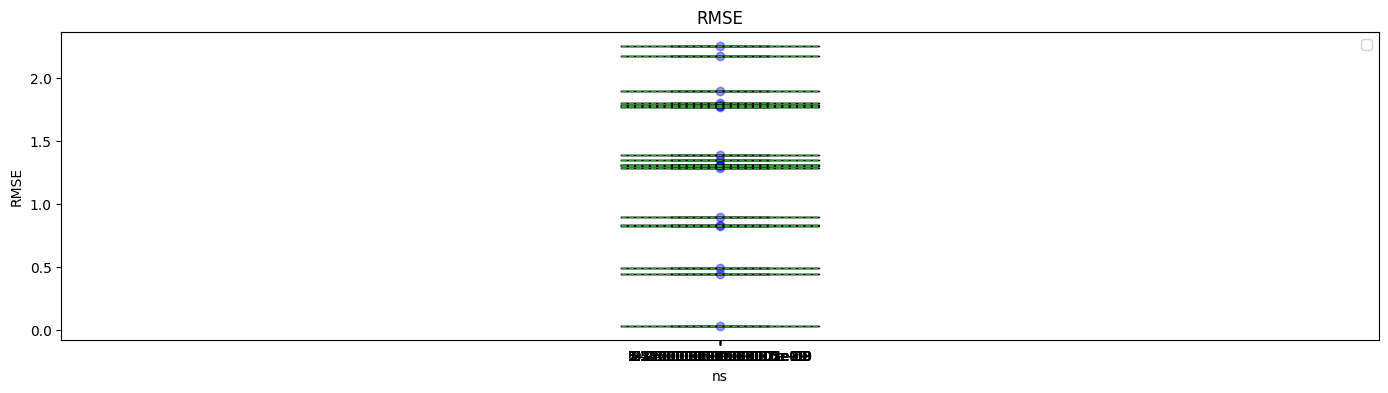

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


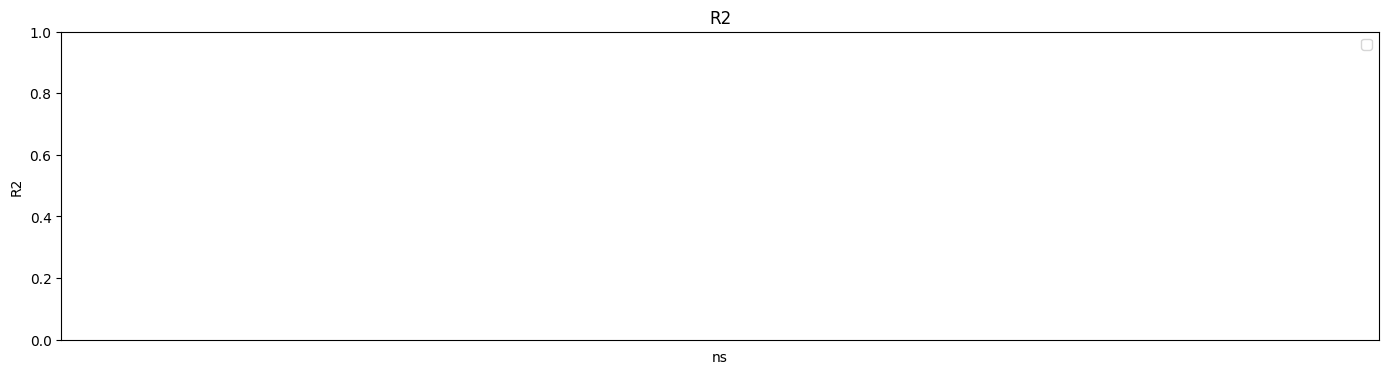

NameError: name 'Calculate_avg_sensitivity' is not defined

In [20]:
#create plots for data
graphs.plot_rmse(rmse,t_idx)
graphs.plot_r2(r2,t_idx)
graphs.plot_sensitivity_area(Temp_gt,Temp_pred,t_idx)
graphs.plot_sensitivity_temperature(Temp_gt,Temp_pred,t_idx)
graphs.plot_saliency(Temp_pred)